Base Model - epochs: 40.0, runtime: 03:36:38, sps: 267.881
Few-shot Model - epochs: 55.0, runtime: 05:11:09, sps: 186.506
CoT Model - epochs: 60.0, runtime: 06:49:29, sps: 141.72


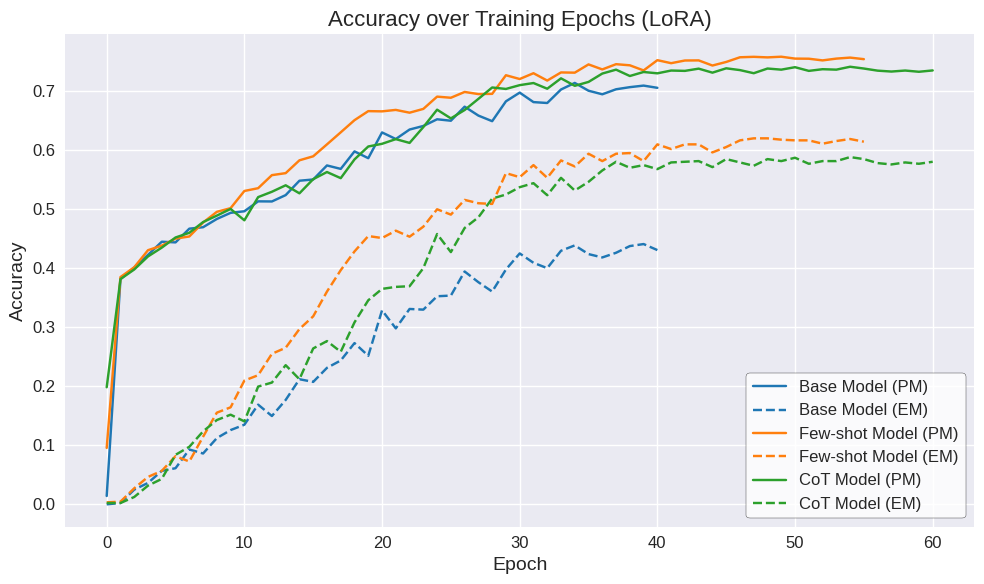

In [ ]:
import json
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

fontsize = 12

plt.rcParams.update({
    "font.size": fontsize,
    "axes.labelsize": fontsize + 2,
    "axes.titlesize": fontsize + 4,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.frameon": True,
})

def sec_to_hour(total):
    h, rest = divmod(total, 3600)
    m, s = divmod(rest, 60)
    return f"{int(h):02d}:{int(m):02d}:{int(s):02d}"
    

def plot_history(histories):
    plt.figure(figsize=(10, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, (label, history) in enumerate(histories.items()):
        epochs = []
        metrics = []
        metrics2 = []
        for record in history:
            metric = "eval_exact_match_accuracy"
            metric2 = "eval_part_match_accuracy"
            if metric in record and "epoch" in record:
                epochs.append(record["epoch"])
                metrics.append(record[metric])
                metrics2.append(record[metric2])
        
            if "train_runtime" in record:
                print(f"{label} - epochs: {record["epoch"]}, runtime: {sec_to_hour(record["train_runtime"])}, sps: {record["train_samples_per_second"]}")
        plt.plot(epochs, metrics2, label=label + " (PM)", color=colors[i], linestyle="-")
        plt.plot(epochs, metrics, label=label + " (EM)", color=colors[i], linestyle="--")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Training Epochs (LoRA)")
    legend = plt.legend()
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_edgecolor("black")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../figures/train_em.png", dpi=300)
    plt.show()


def read_history(file_name: str):
    with open(file_name, mode="r") as f:
        return json.load(f)

# LoRA
models = {
    "Base Model": "../models/reasongr_zero/log_history.json",
    "Few-shot Model": "../models/reasongr_few/log_history.json",
    "CoT Model": "../models/reasongr_cot/log_history.json",
}
histories = {k: read_history(v) for k, v in models.items()}

# Usage
plot_history(histories)

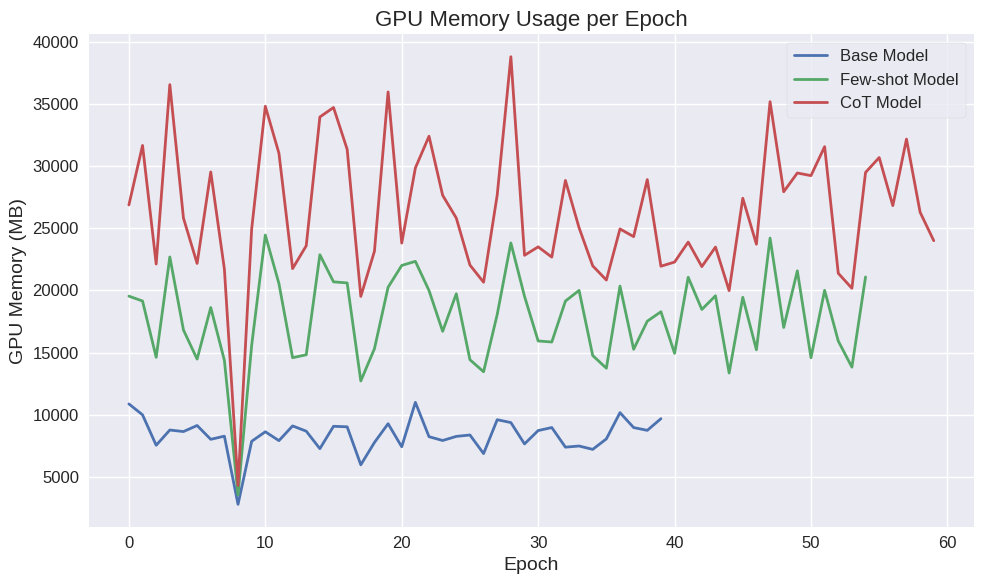

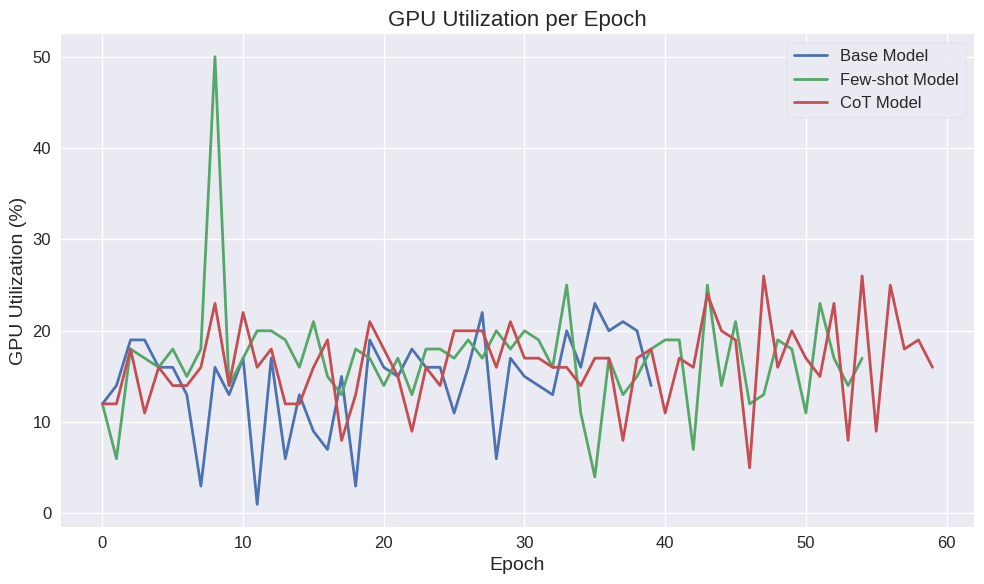

In [2]:
import re

pattern = re.compile(
    r"CPU:\s+([\d.]+)\s+MB,\s+([\d.]+)% \(proc\),\s+([\d.]+)% \(sys\)\s+\|\s+GPU 0:\s+([\d.]+)/([\d.]+)\s+MB,\s+(\d+)% util"
)

def parse_resource_log_line(line):
    match = pattern.search(line)
    if match:
        return {
            "cpu_mem_mb": float(match.group(1)),
            "cpu_proc_percent": float(match.group(2)),
            "cpu_sys_percent": float(match.group(3)),
            "gpu_mem_used_mb": float(match.group(4)),
            "gpu_mem_total_mb": float(match.group(5)),
            "gpu_util_percent": int(match.group(6)),
        }
    return None


import pandas as pd

def parse_log_file(filepath):
    resource_stats = []
    with open(filepath, "r") as f:
        for line in f:
            if "[MONITOR]" in line:
                data = parse_resource_log_line(line)
                if data:
                    resource_stats.append(data)
    return pd.DataFrame(resource_stats)

# No LoRA
# log_files = {
#     "Base Model": "/home/nub/Bachelor/bachelor-thesis/scripts/slurm/training_12632629.out",
#     "Few-shot Model": "/home/nub/Bachelor/bachelor-thesis/scripts/slurm/training_12632683.out",
#     "CoT Model": "/home/nub/Bachelor/bachelor-thesis/scripts/slurm/training_12632694.out",
# }

# QLoRA
log_files = {
    "Base Model": "/home/nub/Bachelor/bachelor-thesis/scripts/slurm/training_12632676.out",
    "Few-shot Model": "/home/nub/Bachelor/bachelor-thesis/scripts/slurm/training_12559361.out",
    "CoT Model": "/home/nub/Bachelor/bachelor-thesis/scripts/slurm/training_12559387.out",
}

dataframes = {label: parse_log_file(path) for label, path in log_files.items()}

import matplotlib.pyplot as plt

def plot_metric_across_models(dataframes, metric, ylabel, title, save_path=None):
    plt.figure(figsize=(10, 6))
    
    for label, df in dataframes.items():
        if metric in df.columns:
            plt.plot(df[metric].values, label=label, linewidth=2)

    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(frameon=True)
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()

# Example usage
plot_metric_across_models(dataframes, metric="gpu_mem_used_mb", ylabel="GPU Memory (MB)", title="GPU Memory Usage per Epoch")
plot_metric_across_models(dataframes, metric="gpu_util_percent", ylabel="GPU Utilization (%)", title="GPU Utilization per Epoch")

In [3]:
for label, df in dataframes.items():
    print(label, df["gpu_mem_used_mb"].median())

Base Model 8496.19
Few-shot Model 18280.19
CoT Model 25424.19


In [4]:
import os

os.chdir("/home/nub/Bachelor/bachelor-thesis/code")

import pynvml
from peft import LoraConfig, TaskType, get_peft_model
from model import load_tokenizer, load_model

os.chdir("/home/nub/Bachelor/bachelor-thesis")

pynvml.nvmlInit()
device_count = pynvml.nvmlDeviceGetCount()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

def get_mem():
    mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
    used_mb = mem.used / 1024**2
    return used_mb

model_name = "google/flan-t5-base"

tokenizer = load_tokenizer(model_name)

lora_config = LoraConfig(
    init_lora_weights="olora",
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules="all-linear",
)


start1 = get_mem()
model = load_model(model_name, tokenizer, False, quantization=False)
end1 = get_mem()
print(f"Load: Start {start1} - End {end1} - Diff {end1 - start1}")

start2 = get_mem()
model = get_peft_model(model, lora_config)
end2 = get_mem()
print(f"Lora: Start {start2} - End {end2} - Diff {end2 - start2}")

print(f"Overall: Start {start1} - End {end2} - Diff {end2 - start1}")

# QLoRA
# Load: Start 402.75 - End 986.625 - Diff 583.875
# Lora: Start 986.625 - End 1056.625 - Diff 70.0
# Overall: Start 402.75 - End 1056.625 - Diff 653.875

# LoRA
# Load: Start 402.75 - End 1150.625 - Diff 747.875
# Lora: Start 1150.625 - End 1222.625 - Diff 72.0
# Overall: Start 402.75 - End 1222.625 - Diff 819.875

KeyboardInterrupt: 